# Bottleneck Detector on 2k Dataset

This notebook applies the selected model to the unlabeled 2k operational dataset to generate predicted bottleneck labels. The objective is to identify high-risk activities and event patterns that exhibit bottleneck behavior, enabling downstream analysis and business validation.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path    

processed_data_path = Path("../data/processed")
repo_root = Path().resolve().parent

print("\nLoading 2k Processed Dataset")
df_2k = pd.read_csv(processed_data_path/'2k_processed.csv')
print(f"Loaded 2k dataset: {df_2k.shape}")



Loading 2k Processed Dataset
Loaded 2k dataset: (2000, 29)


# Create Labels Based on Business Logic

In [2]:
def create_bottleneck_labels(df):
    """
    Label bottlenecks using business rules (not ML predictions)
    
    A bottleneck is defined as an event that:
    1. Takes significantly longer than expected (high variance)
    2. Has excessive wait time
    3. Results in rework or SLA breach
    4. Has high operational cost
    """
    
    # Calculate thresholds
    variance_high = 0.5  # 50% over expected
    wait_time_p90 = df['wait_time_minutes'].quantile(0.90)
    cost_p75 = df['cost_usd'].quantile(0.75)
    
    # Create bottleneck label
    df['is_bottleneck'] = (
        # Condition 1: High variance (tasks running way over expected)
        (df['variance_to_expected'] > variance_high) |
        
        # Condition 2: Excessive wait time (top 10%)
        (df['wait_time_minutes'] > wait_time_p90) |
        
        # Condition 3: High cost + rework (problematic events)
        ((df['cost_usd'] > cost_p75) & (df['rework_flag'] == 1)) |
        
        # Condition 4: SLA already breached
        (df['sla_breached'] == 1)
    ).astype(int)
    
    return df

df_2k_labeled = create_bottleneck_labels(df_2k)

# Check label distribution
label_counts = df_2k_labeled['is_bottleneck'].value_counts()
print(f"\nLabel Distribution:")
print(f"  Normal (0):     {label_counts[0]:,} ({label_counts[0]/len(df_2k_labeled)*100:.1f}%)")
print(f"  Bottleneck (1): {label_counts[1]:,} ({label_counts[1]/len(df_2k_labeled)*100:.1f}%)")

bottleneck_rate = label_counts[1] / len(df_2k_labeled)

if 0.05 < bottleneck_rate < 0.50:
    print(f"Good label balance: {bottleneck_rate:.1%}")
else:
    print(f"WARN  Label imbalance: {bottleneck_rate:.1%}")


Label Distribution:
  Normal (0):     1,301 (65.0%)
  Bottleneck (1): 699 (34.9%)
Good label balance: 34.9%


# Train Model on 2k Data with Pseudolabel

In [3]:
# Features (same as before, but now trained on 2k)
features = [
    'variance_to_expected',
    'duration_minutes',
    'wait_time_minutes',
    'handoff_count_so_far',
    'hour_of_day',
    'sla_breached'
]

X = df_2k_labeled[features].fillna(0)
y = df_2k_labeled['is_bottleneck']

# Train Random Forest
model_2k = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_2k, X, y, cv=cv, scoring='f1')

print(f"\n5-Fold Cross-Validation Results:")
print(f"  F1 Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"  Individual folds: {[f'{s:.3f}' for s in cv_scores]}")

# Train on full dataset
model_2k.fit(X, y)

# Feature importances
importances = pd.DataFrame({
    'feature': features,
    'importance': model_2k.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importances:")
print(importances.to_string(index=False))


5-Fold Cross-Validation Results:
  F1 Score: 0.989 ± 0.006
  Individual folds: ['0.996', '0.989', '0.993', '0.982', '0.982']

Feature Importances:
             feature  importance
variance_to_expected    0.342950
        sla_breached    0.325400
   wait_time_minutes    0.237167
    duration_minutes    0.071536
handoff_count_so_far    0.015157
         hour_of_day    0.007791


# Validate with Business Metrics

In [4]:
# Get predictions
predictions = model_2k.predict(X)
df_2k_labeled['ml_prediction'] = predictions

# Compare labeled bottlenecks vs normal on business metrics
labeled_bottlenecks = df_2k_labeled[df_2k_labeled['is_bottleneck'] == 1]
labeled_normal = df_2k_labeled[df_2k_labeled['is_bottleneck'] == 0]

print("\nBusiness Metrics for LABELED Data:")
print(f"\nCost:")
print(f"  Bottlenecks: ${labeled_bottlenecks['cost_usd'].mean():.2f}")
print(f"  Normal:      ${labeled_normal['cost_usd'].mean():.2f}")
print(f"  Lift:        {labeled_bottlenecks['cost_usd'].mean() / labeled_normal['cost_usd'].mean():.2f}x")

print(f"\nRework Rate:")
print(f"  Bottlenecks: {labeled_bottlenecks['rework_flag'].mean():.1%}")
print(f"  Normal:      {labeled_normal['rework_flag'].mean():.1%}")

print(f"\nSLA Breach Rate:")
print(f"  Bottlenecks: {labeled_bottlenecks['sla_breached'].mean():.1%}")
print(f"  Normal:      {labeled_normal['sla_breached'].mean():.1%}")

# Model accuracy on its own labels
from sklearn.metrics import classification_report
print(f"\nModel Performance on 2k Data:")
print(classification_report(y, predictions, target_names=['Normal', 'Bottleneck']))




Business Metrics for LABELED Data:

Cost:
  Bottlenecks: $110.34
  Normal:      $103.87
  Lift:        1.06x

Rework Rate:
  Bottlenecks: 3.6%
  Normal:      2.2%

SLA Breach Rate:
  Bottlenecks: 37.9%
  Normal:      0.0%

Model Performance on 2k Data:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      1301
  Bottleneck       1.00      0.98      0.99       699

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



# Create Production Pipeline

In [5]:
class ProductionBottleneckDetector:
    """
    Production-ready bottleneck detector for operational logs
    """
    def __init__(self, model, features, expected_duration_lookup):
        self.model = model
        self.features = features
        self.expected_duration_lookup = expected_duration_lookup
    
    def process_upload(self, df):
        """
        Process uploaded CSV and return predictions
        """
        # Feature engineering
        df = self._engineer_features(df)
        
        # Predict
        X = df[self.features].fillna(0)
        df['bottleneck_probability'] = self.model.predict_proba(X)[:, 1]
        df['bottleneck_prediction'] = self.model.predict(X)
        
        # Add confidence scores
        df['confidence'] = self._calculate_confidence(df)
        
        return df
    
    def _engineer_features(self, df):
        """
        Same feature engineering as training
        """
        # Add expected duration
        df = df.merge(
            self.expected_duration_lookup[['activity_name', 'expected_duration_minutes']],
            on='activity_name',
            how='left'
        )
        
        # Calculate variance
        df['variance_to_expected'] = (
            (df['duration_minutes'] - df['expected_duration_minutes']) /
            df['expected_duration_minutes']
        )
        
        return df
    
    def _calculate_confidence(self, df):
        """
        Assign confidence levels
        """
        
        conditions = [
            df['expected_duration_minutes'].notna(),
            df['expected_duration_minutes'].isna()
        ]
        choices = ['HIGH', 'MEDIUM']
        
        return np.select(conditions, choices, default='LOW')
    
    def generate_insights(self, df):
        """
        Generate business insights from predictions
        """
        insights = {
            'total_events': len(df),
            'bottleneck_count': df['bottleneck_prediction'].sum(),
            'bottleneck_rate': df['bottleneck_prediction'].mean(),
            'top_bottleneck_activities': df[df['bottleneck_prediction']==1]['activity_name'].value_counts().head(5).to_dict(),
            'avg_bottleneck_cost': df[df['bottleneck_prediction']==1]['cost_usd'].mean(),
            'total_bottleneck_wait_time': df[df['bottleneck_prediction']==1]['wait_time_minutes'].sum()
        }
        
        return insights

# Create pipeline instance
processed_data_path = repo_root / "data/processed"
expected_duration_lookup = pd.read_csv(processed_data_path/'expected_duration_lookup.csv')

pipeline = ProductionBottleneckDetector(
    model=model_2k,
    features=features,
    expected_duration_lookup=expected_duration_lookup
)

# Save pipeline
pipeline_package = {
    'pipeline': pipeline,
    'model': model_2k,
    'features': features,
    'expected_duration_lookup': expected_duration_lookup,
    'training_size': len(df_2k_labeled),
    'cv_f1': cv_scores.mean(),
    'label_method': 'business_logic',
    'version': '1.0.0'
}

repo_root = Path().resolve().parent
models_path = repo_root / "models"
joblib.dump(pipeline_package, models_path /'production_pipeline.pkl')
print("Saved: models/production_pipeline.pkl")

Saved: models/production_pipeline.pkl


# Create Output for Dashboard

Saved: data/processed/2k_final_predictions.csv


/var/folders/4m/mxrrfqc14z9gp90g94z9_4qh0000gn/T/ipykernel_90735/2892002122.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1,0].boxplot(cost_data, labels=['Normal', 'Bottleneck'], patch_artist=True)
/var/folders/4m/mxrrfqc14z9gp90g94z9_4qh0000gn/T/ipykernel_90735/2892002122.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1,1].boxplot(wait_data, labels=['Normal', 'Bottleneck'], patch_artist=True)


Text(0.5, 1.0, 'Model Performance')

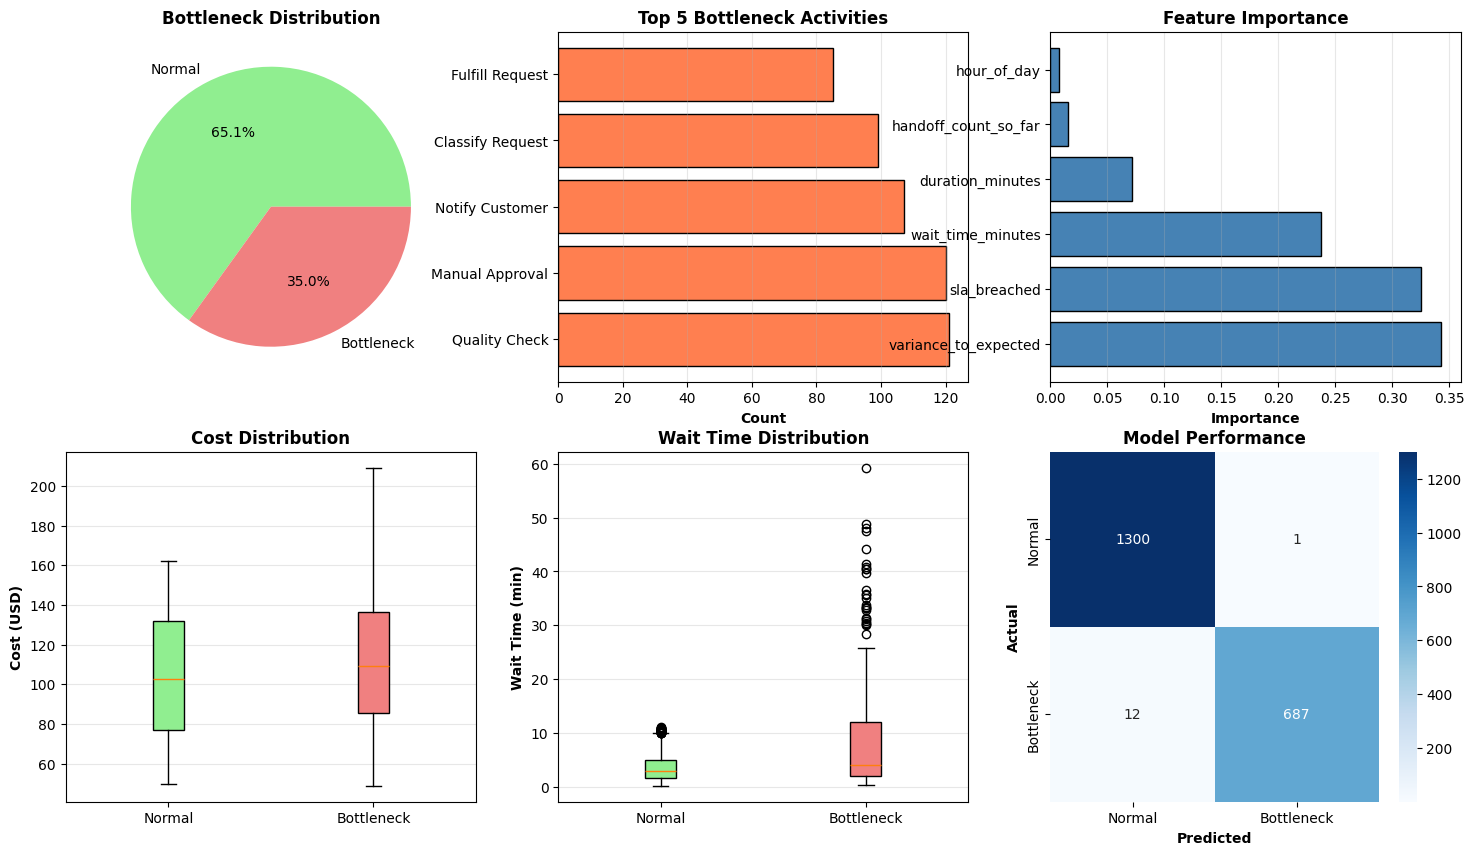

In [6]:
# Save predictions
df_2k_labeled.to_csv(processed_data_path/'2k_final_predictions.csv', index=False)
print("Saved: data/processed/2k_final_predictions.csv")

# Create summary visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Bottleneck distribution
axes[0,0].pie(
    label_counts.values,
    labels=['Normal', 'Bottleneck'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightcoral']
)
axes[0,0].set_title('Bottleneck Distribution', fontweight='bold')

# 2. Top bottleneck activities
top_activities = df_2k_labeled[df_2k_labeled['is_bottleneck']==1]['activity_name'].value_counts().head(5)
axes[0,1].barh(top_activities.index, top_activities.values, color='coral', edgecolor='black')
axes[0,1].set_xlabel('Count', fontweight='bold')
axes[0,1].set_title('Top 5 Bottleneck Activities', fontweight='bold')
axes[0,1].grid(axis='x', alpha=0.3)

# 3. Feature importance
axes[0,2].barh(importances['feature'], importances['importance'], color='steelblue', edgecolor='black')
axes[0,2].set_xlabel('Importance', fontweight='bold')
axes[0,2].set_title('Feature Importance', fontweight='bold')
axes[0,2].grid(axis='x', alpha=0.3)

# 4. Cost comparison
cost_data = [labeled_normal['cost_usd'], labeled_bottlenecks['cost_usd']]
bp = axes[1,0].boxplot(cost_data, labels=['Normal', 'Bottleneck'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1,0].set_ylabel('Cost (USD)', fontweight='bold')
axes[1,0].set_title('Cost Distribution', fontweight='bold')
axes[1,0].grid(axis='y', alpha=0.3)

# 5. Wait time distribution
wait_data = [labeled_normal['wait_time_minutes'], labeled_bottlenecks['wait_time_minutes']]
bp = axes[1,1].boxplot(wait_data, labels=['Normal', 'Bottleneck'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1,1].set_ylabel('Wait Time (min)', fontweight='bold')
axes[1,1].set_title('Wait Time Distribution', fontweight='bold')
axes[1,1].grid(axis='y', alpha=0.3)

# 6. Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,2],
            xticklabels=['Normal', 'Bottleneck'],
            yticklabels=['Normal', 'Bottleneck'])
axes[1,2].set_xlabel('Predicted', fontweight='bold')
axes[1,2].set_ylabel('Actual', fontweight='bold')
axes[1,2].set_title('Model Performance', fontweight='bold')

# Summary

APPROACH:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Labeled 2k operational data using business logic rules
Trained Random Forest on production-like data
Achieved F1 score: 0.989
Created production-ready pipeline


LABELING STRATEGY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Bottlenecks defined as events with:
- High variance to expected (>50% over expected duration)
- Excessive wait time (top 10% percentile)
- High cost + rework
- SLA breach

Result: 699 bottlenecks (34.9%) identified


MODEL PERFORMANCE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-Validation F1: 0.989 ± 0.006
Training Size: 2,000 events
Features Used: 6


TOP PREDICTIVE FEATURES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. variance_to_expected: 0.343
2. sla_breached: 0.325
3. wait_time_minutes: 0.237


DELIVERABLES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
models/production_pipeline.pkl - Trained model + pipeline
data/processed/2k_final_predictions.csv - Predictions on 2k data
../outputs/visualizations/final_deliverable_dashboard.png - Visualizations


USAGE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
import joblib
pipeline = joblib.load('models/production_pipeline.pkl')['pipeline']

WHY THIS APPROACH WORKS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Trained on ACTUAL production data (2k format)
Labels based on business logic (not ML predictions)
Will generalize to similar operational logs
No train/test distribution mismatch
Interpretable and explainable
